2023-12-28 02:09:56.852632: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 02:09:57.452234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 02:09:57.452256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 02:09:57.455081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 02:09:57.738197: I tensorflow/core/platform/cpu_feature_g

Found 136 files belonging to 3 classes.
Using 109 files for training.
Using 27 files for validation.


2023-12-28 02:10:09.250179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/50


2023-12-28 02:10:24.067918: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d1928a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 02:10:24.067976: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-12-28 02:10:24.089730: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 02:10:24.206881: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 16s 2s/step - loss: 1.2228 - accuracy: 0.3211 - val_loss: 1.2125 - val_accuracy: 0.2222
Epoch 2/50
4/4 [==============================] - 6s 2s/step - loss: 1.1906 - accuracy: 0.2569 - val_loss: 1.2562 - val_accuracy: 0.2963
Epoch 3/50
4/4 [==============================] - 6s 2s/step - loss: 1.1117 - accuracy: 0.3119 - val_loss: 1.2497 - val_accuracy: 0.2222
Epoch 4/50
4/4 [==============================] - 6s 2s/step - loss: 1.1330 - accuracy: 0.3394 - val_loss: 1.2315 - val_accuracy: 0.1852
Epoch 5/50
4/4 [==============================] - 6s 2s/step - loss: 1.0941 - accuracy: 0.3578 - val_loss: 1.2610 - val_accuracy: 0.2222
Epoch 6/50
4/4 [==============================] - 6s 2s/step - loss: 1.1301 - accuracy: 0.3761 - val_loss: 1.2577 - val_accuracy: 0.2593
Epoch 7/50
4/4 [==============================] - 6s 2s/step - loss: 1.0860 - accuracy: 0.3486 - val_loss: 1.2493 - val_accuracy: 0.2593
Epoch 8/50
4/4 [==============================] - 6

None
/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


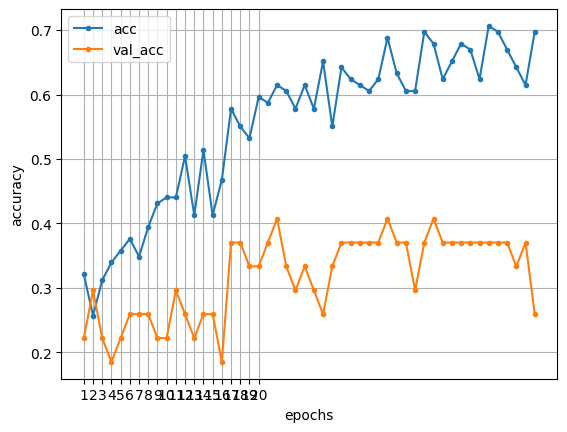

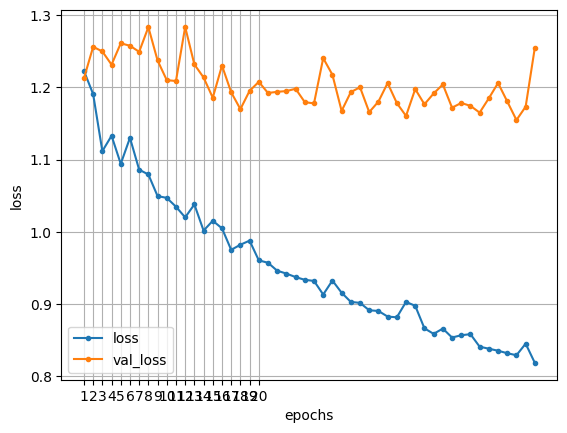

In [1]:
import os
# os.chdir('/code/janken')
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Resizing, Permute
import matplotlib.pyplot as plt
# from .autonotebook import tqdm as notebook_tqdm

import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

from janken_train import plot_result

# from transformers import TFViTModel
from transformers import TFAutoModelForImageClassification

SEED = 1234
IMG_DIR = './images'
BATCH_SIZE = 32
IMAGE_SIZE = 384
NUM_CLASSES = 3
N_EPOCHS = 50


def prepare_dataset():
    train_dataset, valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory=IMG_DIR,
                                            label_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            seed=SEED,
                                            validation_split=0.2,
                                            subset='both'
                                        )
    return train_dataset, valid_dataset


def main():
    train_dataset, valid_dataset = prepare_dataset()
    # TODO: prefetch

    # vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = TFAutoModelForImageClassification.from_pretrained("google/vit-base-patch16-384")
    # vit_model = tf.keras.models.load_model('tf_model.h5')
    vit_model.trainable = False
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    x = Permute((3, 1, 2))(x)
    x = vit_model(x).logits
    # x = vit.pooler_output
    # x = Dense(1024, activation='relu')(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
    optimizer= "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy'],
    )

    history = model.fit(
        train_dataset,
        validation_data = valid_dataset,
        epochs = N_EPOCHS,
        verbose = 1,
        # class_weight=class_weight,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)]
    )
    plot_result(history)
    logger.info(model.summary())
    model.save('test_model.h5')
    
if __name__ == '__main__':
    main()